In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import urllib.request
import numpy as np
import pdb

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score, balanced_accuracy_score
from inspect import signature

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import pairwise_kernels
import warnings
warnings.warn('once')

from sklearn.preprocessing import StandardScaler 
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from scipy import sparse as sp
import time

news_csv = pd.read_csv('OnlineNewsPopularity/OnlineNewsPopularity.csv')


/Users/shiningsunnyday/Documents/GitHub/CS229Final/good_news_venv/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: once


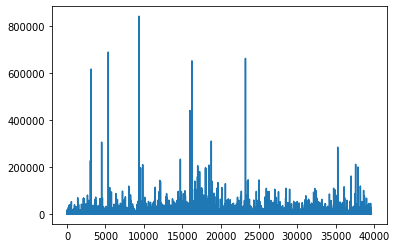

In [2]:
urls = news_csv.url
total_batches = (len(urls) + 100) // 100

def scrape(num_batches):
    for batch in range(num_batches):
        news_scrape = []
        batch_size = 100 if batch < len(urls) // 100 else len(urls) % 100
        prog = round(100 * (batch / ((len(urls) + 100) / 100)))
        print("batch", batch, '%s%% complete' % (prog))
        author_err, tag_err, base_err = 0, 0, 0
        for i in range(batch_size):
            url = urls[100 * batch + i]
            try:
                pg = urllib.request.urlopen(url)
                pg_bytes = pg.read()
                pg_html = pg_bytes.decode('utf8')
                soup = BeautifulSoup(pg_html, "html.parser")
                try:
                    author = soup.find("span", "author_name").a.get_text()
                except AttributeError:
                    author = ""
                    author_err += 1
                result = "".join(list(map(lambda x: x.get_text(), soup.find("section", "article-content").find_all("p"))))
                try:
                    tags = soup.find("footer", "article-topics")
                    tags = list(map(lambda x: x.get_text().lower(), soup.find("footer", "article-topics").find_all("a")))
                except AttributeError:
                    tags = []
                    tag_err += 1
            except:
                base_err += 1
                pass
            news_scrape.append([url, author, result.replace('\n', ''), ','.join(tags)])
        f_write = open("news_contents.txt", 'a')
        np.savetxt(f_write, np.array(news_scrape), delimiter = '|', fmt = '%s')
        f_write.close()
        
def scrape_title(num_batches):
    for batch in range(num_batches):
        batch_size = 100 if batch < len(urls) // 100 else len(urls) % 100
        prog = round(100 * (batch / ((len(urls) + 100) / 100)))
        print("batch", batch, '%s%% complete' % (prog))
        titles = []
        for i in range(batch_size):
            url = urls[100 * batch + i]
            try:
                pg = urllib.request.urlopen(url)
                pg_bytes = pg.read()
                pg_html = pg_bytes.decode('utf8')
                soup = BeautifulSoup(pg_html, "html.parser")
                titles.append([url, soup.find('title').get_text()])
            except:
                pass
        f_write = open("news_title.txt", 'a')
        np.savetxt(f_write, np.array(titles), delimiter = '|', fmt = '%s')
        f_write.close()   

def word_model(path="glove.twitter.27B/glove.twitter.27B.50d.txt"):
    f = open(path,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
        
    f.close()
    return model

g_model = word_model()

shares_lookup = dict(zip(news_csv.url, news_csv.iloc[:,-1]))
shares_dist = np.array(news_csv.iloc[:,-1])

plt.plot(shares_dist)

In [3]:
label = lambda x: int(x > 1400)
arr_labels = lambda x: 1*(x > 1400)
y = arr_labels(shares_dist)

def eda_shares(shares_dist, news_csv):
    plt.figure(0)
    plt.hist(shares_dist[1000:2000], bins=100, range=(0, 8000), color="red")
    # plt.vlines([1250,2500,5000], [0,0,0], [3500,1000,400])
    plt.title('#Shares Density')
    # plt.savefig(fname="./shares_dist.png", transparent=True, format='png', bbox_inches='tight')

    plt.figure(1)
    dates_dist = np.array(news_csv.iloc[:,1])
    plt.scatter(-dates_dist, shares_dist, color="red")
    plt.title('Article Age vs #Shares')
    plt.savefig(fname="./time_shares.png", dpi=500)

    plt.show()


In [4]:
f_read = open("news_contents.txt", 'r')
news_lines = f_read.readlines()
f_title_read = open("good_news/news_title.txt", 'r')
news_titles = f_title_read.readlines()
news_titles_dic = {title.split('|')[0]: title.split('|')[1].strip('\n') for title in news_titles}
news_lines[0].split('|')
n = {news.split('|')[0]: news for news in news_lines}

def metadic(news_csv, news_titles_dic, n):
    news_metadic={}
    for i in range(len(news_csv)):
        url = news_csv.url[i]
        if url in news_titles_dic:
            news_metadic[url] = {"title": news_titles_dic[url].strip('\n'), 
                              "content": n[url].split('|')[2],
                              "author": n[url].split('|')[1],
                              "keywords": n[url].split('|')[3].strip('\n').split(',') if len(n[url].split('|')) > 3 else None}
        else:
            news_metadic[url] = {"title": None,
                             "content": "",
                             "author": None,
                             "keywords": None}
    return news_metadic        

news_metadic = metadic(news_csv, news_titles_dic,n)


In [5]:
# gets keywords from news_metadic
# get_k=lambda news_metadic: [' '.join(k) if k != None else '' 
#                             for k in [news_metadic.get(url,[])['keywords'] 
#                             for url in news_metadic.keys()]]
    
# k_freq_idf = TfidfVectorizer(lowercase=True,stop_words='english',
#                              analyzer='word',strip_accents='unicode',min_df=1)
# key_tf = k_freq_idf.fit_transform(get_k(news_metadic))
# svd = TruncatedSVD(1000,'arpack')
# key_tf_svd = svd.fit_transform(key_tf)

# np.savetxt('./keyw_tf_svd.txt',key_tf_svd)

key_tf_svd=np.loadtxt('./keyw_tf_svd.txt')

In [6]:
swords = set(stopwords.words('english'))

def text_attr(article, vocab_ref):   
    for word in article.split():
        return np.array([])
def batch_text_process(metadic):
    batch = news_csv[:batch_size]
    text_attr_col = pd.DataFrame({'words': [text_attr(metadic[news_csv.iloc[i, 0]][0])
                                            for i in range(len(metadic))]})
    return news_csv.join(text_attr_col)
def article_content_dic(content, pos_set):
    dic_count = {}
    for article in content:
        pos_tags = nltk.pos_tag(nltk.word_tokenize(article))
        nouns = set(filter(lambda x: x[1] in pos_set and x[1] not in swords, pos_tags))
#         nouns = set(filter(lambda x: x[1] not in swords, pos_tags))
        for noun in nouns:
            dic_count[noun] = dic_count[noun]+1 if noun in dic_count else 1
    return {word[0]: dic_count[word] for word in dic_count.keys() if dic_count[word] > 5}
def article_vocab_matrix(vocab_index, content):
    matrix = np.array([[0 for _ in range(len(vocab_index))] for _ in range(len(content))])
    for i in range(len(content)):
        for word in content[i].lower().split():
            if word in vocab_index:
                matrix[i][vocab_index[word]] += 1
    return matrix
tags = 'NN, NNS, NNP, NNPS, JJ, JJR, JJS, VB, VBD, VBG, VBN, VBP, VBZ'.split(', ')
# news_lines
def get_content(start, batch_size):
    return [news_metadic[news_csv.url[i]]['content'] for i in range(start, start+batch_size)]
def train_with_feature(start, batch_size, pos_set):

    batch_content = get_content(start, batch_size)
    vocab_ref = article_content_dic(batch_content, pos_set) 
    vocab_ref_sorted = sorted(vocab_ref, key=lambda x: -vocab_ref[x])
    vocab_index = {vocab_ref_sorted[i]:i for i in range(len(vocab_ref))}
    
    f_matrix = article_vocab_matrix(vocab_index, batch_content)
    clf = MultinomialNB(alpha=1.0)
    train_indices, test_indices = np.array(list(range(batch_size)))[:batch_size*8//10], np.array(list(range(batch_size)))[batch_size*8//10:]
    train_matrix = f_matrix[train_indices]
    test_matrix = f_matrix[test_indices]
    
    y = np.array([label(shares_lookup[news_csv.url[i]]) for i in range(start, start+batch_size)])
    train_y, test_y = y[train_indices], y[test_indices]
    clf.fit(train_matrix, train_y)
    predics = clf.predict(test_matrix)

    return (clf, clf.predict_log_proba(test_matrix), np.mean(1*(predics  == test_y)), vocab_index, f_matrix, y, predics)
def find_best_features(pos_set):
    features = []
    while True: 
        # we only add a feature if its addition is superior to all previous feature sets
        # and break if no such tag is found in an iteration
        prev_score = 0
        top_score = 0; best_tag = None
        for tag in tags:
            features.append(tag)
            score = train_with_feature(batch_content, features)
            print("features", features, "score", score)
            if score > top_score:
                top_score = score
                best_tag = tag
            features.remove(tag)
        if top_score <= prev_score:
            break
        else:
            features.append(best_tag)
        tags.remove(best_tag)
        prev_score = top_score
    return features
def update_content_vecs(clf, start, batch_size, vocab_index, news=news_csv):
    batch_content = get_content(start, start+batch_size)
    naive_score = clf.predict_log_proba(article_vocab_matrix(vocab_index, batch_content))[:,0]
    naive_col = pd.DataFrame({'naive_score': naive_score})
    return news.iloc[start:start+batch_size,:].join(naive_col)
def get_top_words(matrix, y, vocab_index, highest=5):
    v = np.shape(matrix)[1]
    labels = np.array(y)
    pos_samples = matrix[labels == 1, :]
    zero_samples = matrix[labels == 0, :]
    phi_x_1 = (np.sum(pos_samples, axis = 0)+1) / (np.sum(pos_samples)+v)
    phi_x_0 = (np.sum(zero_samples, axis = 0)+1) / (np.sum(zero_samples)+v)
    model = np.log(phi_x_1), np.log(phi_x_0), phi_1, phi_0
    ordered_keys = sorted(range(np.log(phi_x_1).size),
            key = lambda i: (np.log(phi_x_1) - np.log(phi_x_0))[i], reverse = False)
    return np.array(list(vocab_index.keys()))[ordered_keys[:highest]].tolist()
def update_title_vecs(start,end,news=news_csv):
    urls = news.url[start:end]
    vecs = []
    valid_indices = np.arange(start,end)[np.array([url in news_titles_dic for url in urls])]
    for url in urls:
        if url in news_titles_dic:
            w2v = np.array([g_model[w] for w in news_titles_dic[url].lower().split() if w in g_model])
            if not (w2v).size:
                w2v = np.array([g_model[w] for w in url.split('/')[-2].split('-') if w in g_model])
            vecs.append(w2v.mean(axis=0))
    title_vecs = {}
    for i in range(valid_indices.size):
        title_vecs[valid_indices[i]] = vecs[i]

        
    title_col = pd.DataFrame({'title_vecs': title_vecs})
    return news.iloc[valid_indices,:].join(title_col)                  
def update_keyword_vecs(start,end,k_svd,news=news_csv):
    keyword_col = pd.DataFrame({'keyword_vecs':
        {i:k_svd[i] for i in range(start,min(end,len(news)))}
    })
    return news.iloc[start:end].join(keyword_col)
        

In [7]:
def metrics(predics, y):
    return {
        "accuracy": (predics[y == 1].sum()+(1-predics[y == 0]).sum())/y.size,
        "precision": y[predics == 1].mean(),
        "recall": predics[y == 1].mean(),
        "specificity": (1-predics[y == 0]).mean()
    }
def plot_pr(predics, y):
    
    average_precision = average_precision_score(t_y, t_p[:,1])
    precision, recall, _ = precision_recall_curve(y, predics)
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    plt.show()
def train_test_split():
    batches = [100, 250, 500, 1000, 1500, 2000]
    does_length_matter = {}
    for batch_size in batches:
        does_length_matter[batch_size] = []
        for i in range(10000//batch_size):
            score = train_with_feature(batch_size*i, batch_size*(i+1), ['NNS','VBN','VBG'])[2]
            does_length_matter[batch_size].append(score)
            print(batch_size*i, batch_size*(i+1), ":", score)
       

In [8]:
clf, probs, score, vocab_index, matrix, y, predics = train_with_feature(0, 5000, ['NNS','VBN','VBG'])
content_updated = update_content_vecs(clf, 0,37000, vocab_index).reset_index(drop=True)
title_updated = update_title_vecs(0,37000, content_updated).reset_index(drop=True)
updated_csv = update_keyword_vecs(0,37000,key_tf_svd,title_updated)
y = arr_labels(np.array(updated_csv[' shares']))

In [9]:
# titles = np.array([news_titles_dic[url].lower() for url in news_titles_dic.keys()])
news_content_dic = {key: news_metadic[key]['content'] for key in news_metadic.keys()}
content=[str(news_content_dic.get(url, "")) for url in news_csv.url]
titles=[news_titles_dic.get(url,"") for url in news_csv.url]
# shares=[label(shares_lookup.get(url, 1)) for url in news_csv.url]

In [ ]:
# the goal here is to find optimal way to select features via lasso

# C of 6.5 does the best for regular lasso
# most coef if not all are less than 0.01 in magnitude

# lr=LogisticRegression(penalty='l1',C=6.5)
# lr.fit(wv[:-2000],y[:-2000])
# lr.get_params
# good_indices = np.where(np.abs(lr.coef_) > 0.4)[1]
# lr_good=LogisticRegression(penalty='l2',C=6.5).fit(wv[:-2000,good_indices],y[:-2000])
# f1_score(lr_good.predict(wv[-2000:,good_indices]),y[-2000:])

# cutoff of 0.4 seems to prune out bad features the best
# now we can LSA further

# wv_svd=TruncatedSVD(1500,'arpack').fit_transform(wv[:,good_indices])

# after searching 1500 captures > 70% of variance

# summarized into a function below

wv = TfidfVectorizer(lowercase=True,stop_words='english',
                                      ngram_range=(1,6),analyzer='word',strip_accents='unicode',
                                      min_df=1).fit_transform(content)


In [ ]:


def lasso_feature_sel(content,past_start=15000,past_end=36000,C=6.5,thres=0.4,svd_dim=1500): 
    lr=LogisticRegression(penalty='l1',C=C)
    lr.fit(wv[past_start:past_end],y[past_start:past_end])
    good_indices = np.where(np.abs(lr.coef_) > 0.4)[1]
    good_indices = np.where(np.abs(coef_) > thres)[1]
    return TruncatedSVD(svd_dim,'arpack').fit_transform(wv[:,good_indices])

# content_svd = lasso_feature_sel(content)

# past_start=15000;past_end=36000;C=6.5
# lr=LogisticRegression(penalty='l1',C=C)
# lr.fit(wv[past_start:past_end],y[past_start:past_end])
# good_indices = np.where(np.abs(lr.coef_) > 0.4)[1]
# np.savetxt('./lr_good_indices.txt',good_indices)
def lasso_svd_retrieve(wv,svd_dim=1500):
    good_indices=np.loadtxt('./lr_good_indices.txt')
    return TruncatedSVD(svd_dim,'arpack').fit_transform(wv[:,good_indices])


    
    

In [ ]:
num_batches = 39 # treating the last 644 as one batch
# predicts content from start to end using svd-applied word-vec tfidf's
# trained on content from past_start to past_end
def predict_from_past(content,past_start,past_end,start,end,C,ngram):
    past_content = content[past_start:past_end]
    past_y = y[past_start:past_end]
    cur_content = content[start:end]
    cur_y = y[start:end]
    word_vectorizer = TfidfVectorizer(lowercase=True,stop_words='english',
                                      ngram_range=(1,ngram),analyzer='word',strip_accents='unicode',
                                      min_df=1)
    wv=word_vectorizer.fit(past_content)
    lr=LogisticRegression(C=C,penalty='l1').fit(wv.transform(past_content),past_y)
    return (lr.predict(wv.transform(cur_content)),cur_y)
# this experiment yields how far into the past we should look to optimize the eval score
# note the lasso_feature_sel parameters were optimized assuming we look at the entire past
def run_experiment():
    content_scores=[]
    for i in reversed(range(0,36)):
        print("from",1000*i)
        pas=predict_from_past(content,1000*i,36000,36000,37000,6.5,6)
        print("f1 ba",(f1_score(pas[0],pas[1]),balanced_accuracy_score(pas[0],pas[1])))
        content_scores.append((f1_score(pas[0],pas[1]),balanced_accuracy_score(pas[0],pas[1])))
        c_s = {'start':1000*np.array(list(reversed(range(i,36)))),
         'f1_score':np.array([cs[1] for cs in content_scores]),
         'balanced_accuracy':np.array([cs[0] for cs in content_scores])
        }
        
        plt.plot(c_s['start'],c_s['f1_score'],marker='o',markerfacecolor='blue')
        plt.plot(c_s['start'],c_s['balanced_accuracy'],marker='o',markerfacecolor='green')
        plt.title("F1 and Average Recall vs Starting Batch")
        plt.savefig("./f1ba_start.png",dpi=500)
        plt.show()
    return content_scores
    
# result: seems best to start with past_start=15000
# max f1 is < 0.5, with low precision and recall

# content_scores=run_experiment()


# np.concatenate(updated_csv.title_vecs.values).reshape(batch_size,-1).shape


In [ ]:
# this experiment is for how far back we should look at titles (with tfidf)
# to maximize eval score from 36000 to 37000
# whereas we used 6 for content ngrams, here we play by ear and use 3

# title_scores=[]
# title_models=[]
# for i in reversed(range(36)):
#     print("from",1000*i)
#     pas=predict_from_past(titles,1000*i,36000,36000,37000,6,3)
#     title_scores.append((f1_score(pas[0],pas[1]),balanced_accuracy_score(pas[0],pas[1])))
#     t_s = {'start':1000*np.array(list(reversed(range(i,36)))),
#          'f1_score':np.array([ts[1] for ts in title_scores]),
#          'balanced_accuracy':np.array([ts[0] for ts in title_scores])
#         }
#     plt.plot(t_s['start'],t_s['f1_score'],marker='o',markerfacecolor='blue')
#     plt.plot(t_s['start'],t_s['balanced_accuracy'],marker='o',markerfacecolor='green')
#     plt.title("F1 and Average Recall vs Starting Batch -- Titles")
#     plt.savefig("./f1ba_start_titles.png",dpi=500)
#     plt.show()



In [ ]:
# construct transformed tfidf matrix
# perform SVD and return best features
# will be used for titles as well as content
def reduce_to_best(titles,start,batch_size,past_start,past_end=36000,
                   ngram=2,trunc_size=1000):
    # from experimenting above, only past_start=27000 to past_end=36000 is needed
    wv=TfidfVectorizer(lowercase=True,stop_words='english',
                                      ngram_range=(1,ngram),analyzer='word',strip_accents='unicode',
                                      min_df=1).fit(titles[past_start:past_end])
    wv=wv.transform(titles[start:start+batch_size])
    svd=TruncatedSVD(trunc_size,'arpack').fit(wv)
    print(np.sum(svd.explained_variance_ratio_))
    X=svd.transform(wv)
    return X/np.max(np.abs(X),axis=0)    
def get_features(updated_csv,start,batch_size):
    feature_vecs = updated_csv.drop([' shares','title_vecs','keyword_vecs'],axis=1).iloc[:,1:].values
    t_vecs = np.concatenate(updated_csv.title_vecs.values).reshape(batch_size,-1)
    k_vecs = np.concatenate(updated_csv.keyword_vecs.values).reshape(batch_size,-1)
    feature_vecs = np.hstack((feature_vecs, t_vecs, k_vecs))
    max_observed = np.max(np.abs(feature_vecs),axis=0)
    return np.hstack((feature_vecs/max_observed, 
                      reduce_to_best(titles,start,batch_size,27000),
                      lasso_svd_retrieve(wv[start:start+batch_size,:])))
# assumes y has two labels!
def train_val_test_split(x, y, split=0.8):
    pos_x = x[y==1]; pos_y = y[y==1]
    neg_x = x[y==0]; neg_y = y[y==0]
    pos_perm = np.random.permutation(pos_x.shape[0])
    neg_perm = np.random.permutation(neg_x.shape[0])
    pos_x = pos_x[pos_perm]; pos_y = pos_y[pos_perm]
    neg_x = neg_x[neg_perm]; neg_y = neg_y[neg_perm]

    ro = lambda x: int(x*split)+1
    return {'x_train': np.append(pos_x[:ro(pos_y.size)], neg_x[:ro(neg_y.size)], axis=0),
            'y_train': np.append(pos_y[:ro(pos_y.size)], neg_y[:ro(neg_y.size)]),
            'x_test': np.append(pos_x[ro(pos_y.size):], neg_x[ro(neg_y.size):], axis=0),
            'y_test': np.append(pos_y[ro(pos_y.size):], neg_y[ro(neg_y.size):])}

norm_features = get_features(updated_csv,0,37000)
y = arr_labels(np.array(updated_csv[' shares']))
data = {'x_train':norm_features[:36000],
        'x_eval':norm_features[36000:],
        'y_train':y[:36000],
        'y_eval':y[36000:]}


In [ ]:


# anatomy of x's 3610 features is as follows:
# first 60 are original numerical features
# next 100 are title and keyword word2vec
# next 1000 are title vecs
# final 1500 is tfidf features after lasso and lsa

# a suitable kernel is:
 
def article_kernel(X1,X2,k1,k2):
    p_k1=pairwise_kernels(X1[:,:60],X2[:,:60].T,metric=k1)
    w2v=np.dot(X1[:,60:160],X2[:,60:160].T)
    p_k2=pairwise_kernels(X1[:,-1500:],X2[:,-1500:].T,metric=k2)
    return p_k1+w2v+p_k2
    

# data['x_train'].shape

data['x_train']=np.hstack((data['x_train'][:,:160],data['x_train'][:,-1500:]))
data['x_eval']=np.hstack((data['x_eval'][:,:160],data['x_eval'][:,-1500:]))

In [ ]:
evalu = {}

def title_w2v_baseline(data, vec_len=50):
    gram_train = pairwise_kernels(data['x_train'][:,-vec_len:], metric="cosine")
    gram_test = pairwise_kernels(data['x_test'][:,-vec_len:], metric="cosine")
    svc = SVC(kernel="precomputed")
    svc.fit(gram_train, data['y_train'])
    return metrics(svc.predict(gram_train), data['y_train'])

def train_with_svc(data, evalu):
    svc = SVC(kernel="linear",verbose=10)
    svc.fit(data['x_train'], data['y_eval'])
    predics = svc.predict(data['x_eval'])
    evalu["linear"] = metrics(predics, data['y_eval'])
    
    gram_train = pairwise_kernels(data['x_train'], metric="cosine")
    gram_test = pairwise_kernels(data['x_eval'], metric="cosine")
    svc = SVC(kernel="precomputed")
    svc.fit(gram_train, data['y_train'])
    evalu["cosine"] = metrics(svc.predict(gram_train), data['y_train'])
    
    # param_grid = {"gamma": np.logspace(-10, 10, 11)}
    # svc = GridSearchCV(SVC(kernel="rbf"), param_grid=param_grid, cv=5)
    # svc.fit(data['x_train'], data['y_train'])
    # to save time, this grid search gives gamma=1e-4
    svc = SVC(kernel="rbf", gamma=1e-4,verbose=10)
    svc.fit(data['x_train'], data['y_train'])
    predics = svc.predict(data['x_eval'])
    evalu["rbf"] = metrics(predics, data['y_eval'])
    
    # found after trial and error with np.logspace
    # param_grid={"degree":np.linspace(2.5,3.5,3),"coef0":np.linspace(1.5,2.5,5),"gamma":np.linspace(0.02,0.04,5)}
    # svc = GridSearchCV(SVC(kernel="poly"),verbose=10,param_grid=param_grid,scoring='balanced_accuracy',cv=5)
    svc = SVC(kernel="poly", gamma=0.03, coef0=2.25, degree=3,verbose=10)
    svc.fit(data['x_train'], data['y_train'])
    predics = svc.predict(data['x_eval'])
    evalu["poly"] = metrics(predics, data['y_eval'])
    
    return

def train_with_lr(data,reg=2.0):
    # regularized logistic regression on new data with titlevec
    # mlp = GridSearchCV(LogisticRegression(),
    #                    param_grid={"C":np.linspace(1,2,5),'solver':['liblinear','lbfgs']},cv=3,verbose=10,
    #                    scoring="f1_micro")

    # best one is 1.0, l1
    mlpl1 = LogisticRegression(C=reg,verbose=10,solver='saga',penalty='l1')
    mlpl2 = LogisticRegression(C=reg,verbose=10,solver='saga',penalty='l2')
    mlpl1.fit(data['x_train'],data['y_train'])
    mlpl2.fit(data['x_train'],data['y_train'])
    return mlpl1,mlpl2

# for reg in np.linspace(1,3,5):
#     mlpl1,mlpl2 = train_with_lr(data,reg=reg)
#     print(reg)
#     print(metrics(mlpl1.predict(data['x_eval']),data['y_eval']))
#     print(metrics(mlpl2.predict(data['x_eval']),data['y_eval']))


kerns = ['additive_chi2', 'chi2', 'linear', 'poly', 'polynomial', 'rbf',
'laplacian', 'sigmoid', 'cosine']
for k1 in kerns:
    for k2 in kerns:
        print("k1",k1,"k2",k2)
        svc = SVC(kernel=article_kernel(k1,k2),gamma=1e-4)
        svc.fit(data['x_train'],data['y_train'])
        print(metrics(svc.predict(data['x_eval']),data['y_eval']))




In [ ]:
# random forests

rfc_grid={}
# 5 is approx s
# we should have limited depth, as otherwise rfc will abuse the tfidf/lsa features
# we start conservative with low bias
rfc = RandomForestClassifier(n_estimators=100,verbose=10)
rfc.fit(data['x_train'],data['y_train'])
f1_score(rfc.predict(data['x_eval']),data['y_eval'])